In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
species = ["blackgrass", "charlock", "cleavers", "fat hen", "maize", "wheat"]
data_directory = 'C:/Users/Maanz-AI/Downloads/data_task1'
train_directory = os.path.join(data_directory, 'train')
val_directory = os.path.join(data_directory, 'val')
test_directory = os.path.join(data_directory, 'test')

In [6]:
# Making dataframe
train_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_directory, sp)):
        train_data.append(['train/{}/{}'.format(sp, file), species_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'SpeciesId','Species'])
train.head()

,File,SpeciesId,Species
0,train/blackgrass/blackgrass.100.png,0,blackgrass
1,train/blackgrass/blackgrass.102.png,0,blackgrass
2,train/blackgrass/blackgrass.104.png,0,blackgrass
3,train/blackgrass/blackgrass.105.png,0,blackgrass
4,train/blackgrass/blackgrass.106.png,0,blackgrass


In [7]:
# Randomize
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train))

In [8]:
# Making dataframe fro test
val_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(val_directory, sp)):
        val_data.append(['val/{}/{}'.format(sp, file), species_id, sp])
        
val = pd.DataFrame(val_data, columns=['File', 'SpeciesId','Species'])
val.head()

,File,SpeciesId,Species
0,val/blackgrass/blackgrass.109.png,0,blackgrass
1,val/blackgrass/blackgrass.112.png,0,blackgrass
2,val/blackgrass/blackgrass.116.png,0,blackgrass
3,val/blackgrass/blackgrass.12.png,0,blackgrass
4,val/blackgrass/blackgrass.120.png,0,blackgrass


In [9]:
# Making dataframe fro test
test_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(test_directory, sp)):
        test_data.append(['test/{}/{}'.format(sp, file), species_id, sp])
        
test = pd.DataFrame(test_data, columns=['File', 'SpeciesId','Species'])
test.head()

,File,SpeciesId,Species
0,test/blackgrass/blackgrass.1.png,0,blackgrass
1,test/blackgrass/blackgrass.10.png,0,blackgrass
2,test/blackgrass/blackgrass.101.png,0,blackgrass
3,test/blackgrass/blackgrass.103.png,0,blackgrass
4,test/blackgrass/blackgrass.127.png,0,blackgrass


In [10]:
image_size=82
IMAGE_SIZE=82

def read_image(filepath):
    return cv2.imread(os.path.join(data_directory, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
def create_mask(image):
    # Convert from BGR to HSV color-space to extract colored object
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range of green in HSV
    lower_green = np.array([30, 100, 50])
    upper_green = np.array([85, 255, 255])
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    # We will use a morphological operation called closing to close small holes in the image
    # We need a kernel or structuring element to determine the nature of the operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_image(image):
    mask = create_mask(image)
    res = cv2.bitwise_and(image, image, mask=mask) # Bitwise-AND mask and original image
    return res

In [12]:
X_train = np.zeros((train.shape[0], image_size, image_size, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    image_segmented = segment_image(image)
    X_train[i] = resize_image(image_segmented, (image_size, image_size))

X_train = X_train / 255.
print('Train Shape: {}'.format(X_train.shape))

1287it [00:12, 99.20it/s] 

Train Shape: (1287, 82, 82, 3)


In [13]:
Y_train = train['SpeciesId'].values
Y_train = to_categorical(Y_train, num_classes=12)
print('Train Shape: {}'.format(Y_train.shape))

Train Shape: (1287, 12)


In [14]:
X_val = np.zeros((val.shape[0], image_size, image_size, 3))
for i, file in tqdm(enumerate(val['File'].values)):
    image = read_image(file)
    image_segmented = segment_image(image)
    X_val[i] = resize_image(image_segmented, (image_size, image_size))

X_val = X_val / 255.
print('Val Shape: {}'.format(X_val.shape))

389it [00:03, 99.28it/s] 

Val Shape: (389, 82, 82, 3)


In [15]:
Y_val = val['SpeciesId'].values
Y_val = to_categorical(Y_val, num_classes=12)
print('Val Shape: {}'.format(Y_val.shape))

Val Shape: (389, 12)


In [16]:
X_test = np.zeros((test.shape[0], image_size, image_size, 3))
for i, file in tqdm(enumerate(test['File'].values)):
    image = read_image(file)
    image_segmented = segment_image(image)
    X_test[i] = resize_image(image_segmented, (image_size, image_size))

X_test = X_test / 255.
print('Test Shape: {}'.format(X_test.shape))

412it [00:03, 104.41it/s]

Test Shape: (412, 82, 82, 3)


In [17]:
Y_test = test['SpeciesId'].values
Y_test = to_categorical(Y_test, num_classes=12)
print('Test Shape: {}'.format(Y_test.shape))

Test Shape: (412, 12)


In [18]:
BATCH_SIZE = 16
EPOCHS = 50



In [64]:
def construct_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                activation='relu'))
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten()) # Flatten the input
    model.add(Dense(256, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    # Configure the learning process
    # The loss function is the objective that the model will try to minimize
    # For any classification problem, use accuracy metric
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.summary()
    return model
construct_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 78, 78, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 37, 37, 64)       

In [ ]:
def train_model():
    model = construct_model()
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
    # Generates batches of image data with data augmentation
    datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically
    
    datagen.fit(X_train)
    # Fits the model on batches with real-time data augmentation
    hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   callbacks=[annealer, checkpoint],
                   validation_data=(X_val, Y_val))
train_model()

In [ ]:
final_model = load_model('C:/Users/Maanz-AI/model.h5')
final_loss, final_accuracy = final_model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

In [ ]:
import matplotlib.pyplot as plt
Y_pred = final_model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)




In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred, target_names=species))

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

In [47]:
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn import svm

In [24]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
train_x_bf = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(X_val, batch_size=32, verbose=1)

13/13 [==============================] - 3s 196ms/step


In [49]:
from sklearn import linear_model
Y_train = train['SpeciesId'].values
clf = svm.SVC()
clf.fit(train_x_bf, Y_train)
valid_preds = clf.predict(valid_x_bf)

In [50]:
Y_val = val['SpeciesId'].values
print('Validation Xception Accuracy {}'.format(accuracy_score(Y_val, valid_preds)))

Validation Xception Accuracy 0.7352185089974294


In [56]:
test_x_bf = xception_bottleneck.predict(X_test, batch_size=32, verbose=1)
Y_pred = clf.predict(test_x_bf)

13/13 [==============================] - 3s 203ms/step


In [57]:
Y_test = test['SpeciesId'].values
print('Validation Xception Accuracy {}'.format(accuracy_score(Y_test, Y_pred)))

Validation Xception Accuracy 0.7378640776699029


In [59]:
Y_test = test['SpeciesId'].values
Y_test = to_categorical(Y_test, num_classes=12)
Y_true = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_true, Y_pred)

Text(0.5, 145.31999999999996, 'Predicted')

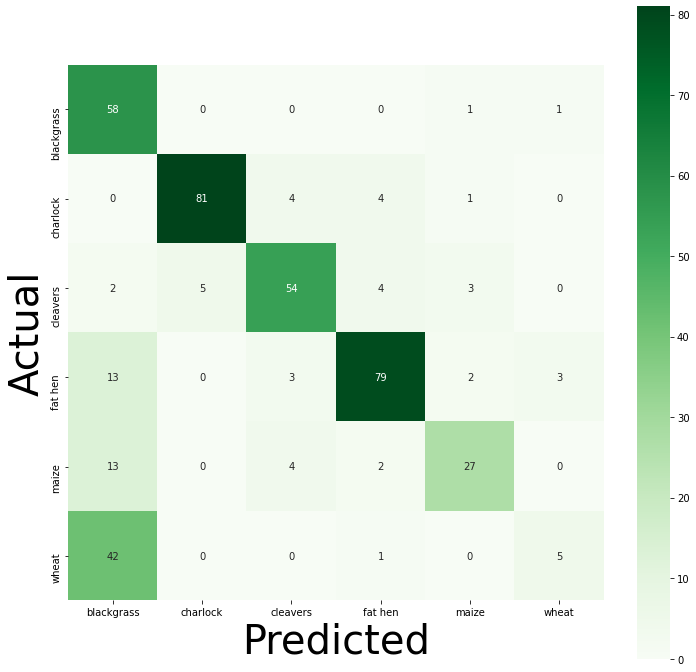

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [62]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.96666667 0.9        0.79411765 0.79       0.58695652 0.10416667]
[0.19886364 0.01552795 0.03197674 0.03525641 0.01912568 0.01098901]


In [63]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred, target_names=species))

              precision    recall  f1-score   support

  blackgrass       0.45      0.97      0.62        60
    charlock       0.94      0.90      0.92        90
    cleavers       0.83      0.79      0.81        68
     fat hen       0.88      0.79      0.83       100
       maize       0.79      0.59      0.68        46
       wheat       0.56      0.10      0.18        48

    accuracy                           0.74       412
   macro avg       0.74      0.69      0.67       412
weighted avg       0.78      0.74      0.72       412

